<a href="https://colab.research.google.com/github/jutrera/InnoSoft-2018/blob/master/InnoSoft_2018_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InnoSoft 2018 - Keras basics

## Conectar tus cuentas de Google (Colaboratory con Drive)
En primer lugar, debemos poder conectar con nuestra cuenta de Drive, ya sea para usar los archivos allí definidos o para salvar nuestros modelos entrenados, etc.

El siguiente código conecta con tu cuenta de Google, te solicita los permisos de acceso y te suministra un código, que deberás insertar en el cuadro de texto que te pide durante la ejecución. Una vez hecho esto, montará una unidad en local de la cuenta de Drive.

*Introducir el código que te dará Google*

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...


*Introdducir el código que te dará Google*

In [2]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


Montamos la unidad y testeamos que disponemos del sistema de ficheros de nuestra cuenta de Drive.

In [0]:
!mkdir -p drive 
!google-drive-ocamlfuse drive

In [4]:
print('Files in Drive:')
!ls drive/

Files in Drive:
 ChestXRay	    CuestionarioFinal.zip  'MURA Hand'	 MyDriveprediction.csv
'Colab Notebooks'  'InnoSoft 2018'	    MyDrive	 others


Ahora debemos definir la ruta base donde queremos trabajar

In [0]:
#Introducir la ruta de esta forma: 'drive/mirutabase'
path_base = 'drive/others'

## Importando las librerías básicas
Ahora importamos las librerías que comunmente suelen usarse (numpy, scipy, matplotlib, etc). No todas serán necesarias, por lo que, por lo general, incluiremos las que nos haga falta

In [0]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn
import pandas as pd
import pickle

Ahora incluiremos las de Keras. Keras va montado sobre un framework de más bajo nivel (Theano, Tensorflow, CNTK...). Por defecto usa Tensorflow, pero podemos cambiarlo según nuestras necesidades. Por ahora, usaremos Tensorflow.

In [7]:
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import layer_utils, np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras import losses
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

Using TensorFlow backend.


In [8]:
!pip install keras-metrics
import keras_metrics

##Preparando el conjunto de datos
Vamos a trabajar en esta primera parte de introducción con un dataset sencillo y muy conocido (sobre todo para el aprendizaje). El dataset de imágenes **CIFAR-100** es un conjunto de 50.000 imágenes de 32x32x3 para entrenar y 10.000 para entrenamiento, etiquetadas en **100 categorías** distintas.

In [9]:
from keras.datasets import cifar100

(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 43s 0us/step


Lo que hemos hecho es cargar los datos en los siguientes conjuntos de datos:


*   **x_train_original** es el conjunto de imágenes que usaremos para entrenar
*   **y_train_original** es el conjunto de las categorías de cada imagen de entrenamiento
*   **x_test_original** es el conjunto de imágenes que usaremos para validar
*   **y_test_original** es el conjunto de las categoría de cada imagen de validación

Vamos a ver una imagen



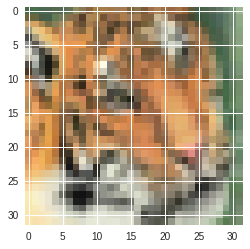

In [10]:
imgplot = plt.imshow(x_train_original[124])
plt.show()

### One hot encoding
One-Hot-encoding consiste en, a partir de la etiqueta de clase de una imagen, lo pasamos a una matriz de dimensiones **nº de imágenes x nº de clases**. Es decir. si tenemos el conjunto de clases *y_test_original* con esta forma:

In [11]:
print(y_test_original)

[[49]
 [33]
 [72]
 ...
 [51]
 [42]
 [70]]


y generamos el conjunto *one-hot-encoding*

In [0]:
y_train = np_utils.to_categorical(y_train_original, 100)
y_test = np_utils.to_categorical(y_test_original, 100)

Podremos ver como es.

In [13]:
print('Conjunto one-hot')
print(y_test)
print()
print('Primera imagen en one-hot')
print(y_test[124])

Conjunto one-hot
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Primera imagen en one-hot
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### Normalizar las imágenes
El conjunto de las imágenes es una matriz en la que cada elemento (imagen) es una matriz de 3 canales de color con el valor de color de cada pixel. Para que el proceso de aprendizaje sea más eficiente, siempre es preferible que los valores estén entre 0 y 1. Esto es lo que llamamos normalizar.

In [14]:
print('Sin normalizar')
print(x_train_original[0])

Sin normalizar
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [195 205 193]
  [212 224 204]
  [182 194 167]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [170 176 150]
  [161 168 130]
  [146 154 113]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [189 199 169]
  [166 178 130]
  [121 133  87]]

 ...

 [[148 185  79]
  [142 182  57]
  [140 179  60]
  ...
  [ 30  17   1]
  [ 65  62  15]
  [ 76  77  20]]

 [[122 157  66]
  [120 155  58]
  [126 160  71]
  ...
  [ 22  16   3]
  [ 97 112  56]
  [141 161  87]]

 [[ 87 122  41]
  [ 88 122  39]
  [101 134  56]
  ...
  [ 34  36  10]
  [105 133  59]
  [138 173  79]]]


Simplemente, dividiremos la matriz por 255 (el mayor valor)

In [15]:
x_train = x_train_original/255
x_test = x_test_original/255

print('Normalizado')
print(x_train[0])

Normalizado
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.76470588 0.80392157 0.75686275]
  [0.83137255 0.87843137 0.8       ]
  [0.71372549 0.76078431 0.65490196]]

 [[1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.66666667 0.69019608 0.58823529]
  [0.63137255 0.65882353 0.50980392]
  [0.57254902 0.60392157 0.44313725]]

 [[1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [1.         1.         1.        ]
  ...
  [0.74117647 0.78039216 0.6627451 ]
  [0.65098039 0.69803922 0.50980392]
  [0.4745098  0.52156863 0.34117647]]

 ...

 [[0.58039216 0.7254902  0.30980392]
  [0.55686275 0.71372549 0.22352941]
  [0.54901961 0.70196078 0.23529412]
  ...
  [0.11764706 0.06666667 0.00392157]
  [0.25490196 0.24313725 0.05882353]
  [0.29803922 0.30196078 0.07843137]]

 [[0.47843137 0.61568627 0.25882353]
  [0.47058824 0.60784314 

## Preparando el entorno de Keras
Debemos especificar a Keras en qué fase estamos (entrenamiento) y, para las imágenes, donde están los canales de color. En la matriz del conjunto de imágenes, los canales se pueden presentar al principio (channels_first) o al final (channel_last).

In [0]:
K.set_learning_phase(1)
K.set_image_data_format('channels_last')

## Ejemplo básico: una red neuronal simple
Para ilustrar como se crea un modelo enKeras, vamos a empezar entrenando una red neuronal. Para ello, creamos una función que nos devuelva el modelo.

![regular neural net](http://jesusutrera.com/articles/img/RedNeuronalArtificial.png)

In [0]:
def create_regular_nn():
  model = Sequential()
  model.add(Flatten(input_shape=(32, 32, 3), name="Input_layer"))
  model.add(Dense(1000, activation='relu', name="Hidden_layer_1"))
  model.add(Dense(500, activation='relu', name="Hidden_layer_2"))
  model.add(Dense(100, activation='softmax', name="Output_layer"))
  
  return model

Declaramos un modelo sequencial, que es una pila de capas de neuronas. Seguidamente, especificamos que la matriz de entrada la vamos a convertir en un array de 1 dimención para generar los parámetros de entrada. Una vez que tenemos la capa de entrada (32x32x3=3072 parámetros) con los valores de los pixeles normalizados, creamos las dos capas intermedias. La primera tendrá 1000 nodos conectados a los 3072 nodos de entrada. La segunda capa intermedia conecta los 1000 nodos  de la primera con 500 nodos. La [función de activación](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_activaci%C3%B3n) para cada nodo de estas dos capas será ReLu. Finalmente, la capa de salida debe contener tantos nodos como clases tengamos (en este caso 100) y la función de activación para clasificación múltiple es Softmax.

Invocamos a la función para obtener el modelo. Ahora debemos compilar el modelo inicializándo algunos parámetros:


*   **loss**. Función de pérdida (ver [loss function](https://isaacchanghau.github.io/post/loss_functions/))
*   **optimizer**. Optimizador de la tasa de aprendizaje (ver [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10))
*   **metrics**. Métricas que vamos a usar para evaluar los resultados del entrenamiento.

En nuestro ejemplo vamos a usar la función de coste *entropía cruzada para clasificación múltiple*, el *descenso de gradiente* como optimizador y las métricas de *acierto*, *precision/recall* y *media de los errores cuadráticos*. Podemos cambiarlos para que vaya mejor con el modelo a entrenar y Keras dispone de varias opciones.


In [0]:
regularNN = create_regular_nn()
regularNN.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])

Vamos a ver un resumen del modelo creado.

In [19]:
regularNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 3072)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 1000)              3073000   
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 500)               500500    
_________________________________________________________________
Output_layer (Dense)         (None, 100)               50100     
Total params: 3,623,600
Trainable params: 3,623,600
Non-trainable params: 0
_________________________________________________________________


Lo interesante aquí es que tenemos poco más de **tres millones y medio de parámetros** (variables) a entrenar.

Ahora vamos a entrenar el modelo. Para ello, vamos a usar el metodo **fit** (ver [referencia](https://keras.io/models/sequential/) de Keras).

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)

rnn_history = regularNN.fit(x=x_train, y=y_train, batch_size=32, epochs=15, verbose=1, validation_data=(x_test, y_test), shuffle=True, callbacks=[reduce_lr])

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 294us/step - loss: 4.1719 - acc: 0.0718 - mean_squared_error: 0.0097 - val_loss: 3.9228 - val_acc: 0.0997 - val_mean_squared_error: 0.0096
Epoch 2/15
50000/50000 [==============================] - 13s 256us/step - loss: 3.7875 - acc: 0.1297 - mean_squared_error: 0.0095 - val_loss: 3.7670 - val_acc: 0.1326 - val_mean_squared_error: 0.0095
Epoch 3/15
50000/50000 [==============================] - 13s 255us/step - loss: 3.6290 - acc: 0.1575 - mean_squared_error: 0.0093 - val_loss: 3.6334 - val_acc: 0.1602 - val_mean_squared_error: 0.0093
Epoch 4/15
50000/50000 [==============================] - 13s 258us/step - loss: 3.5233 - acc: 0.1769 - mean_squared_error: 0.0092 - val_loss: 3.5452 - val_acc: 0.1741 - val_mean_squared_error: 0.0092
Epoch 5/15
50000/50000 [==============================] - 13s 257us/step - loss: 3.4412 - acc: 0.1937 - mean_squared_error: 0.0091 - val_loss: 3.5

Veamos unas gráficas de como ha ido el entrenamiento. Para ello, usamos el histórico obtenido en la función **fit**.

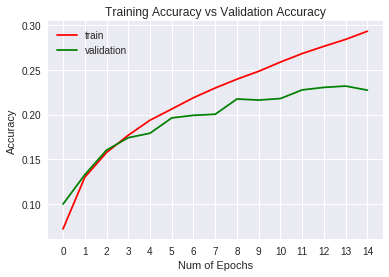

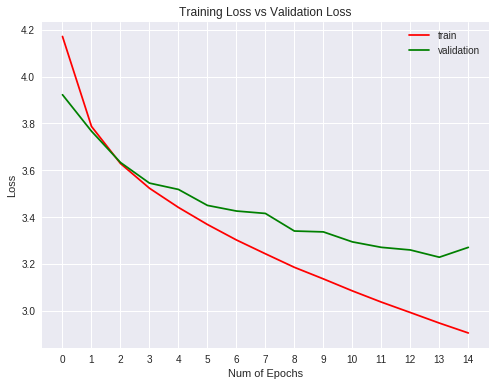

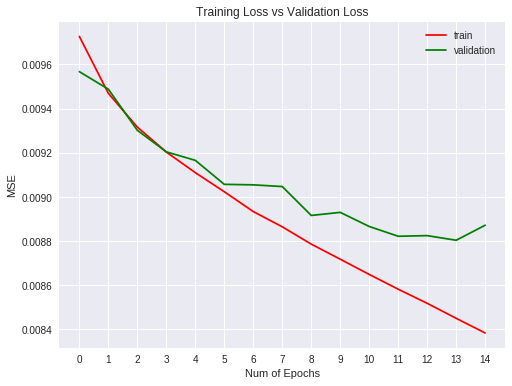

In [21]:
plt.figure(0)
plt.plot(rnn_history.history['acc'],'r')
plt.plot(rnn_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(rnn_history.history['loss'],'r')
plt.plot(rnn_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(rnn_history.history['mean_squared_error'],'r')
plt.plot(rnn_history.history['val_mean_squared_error'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

Vamos a evaluar contra el conjunto de datos de validación. Tener en cuenta que durante el proceso de entrenamiento, la validación se hizo en los batcesy es ahora cuando evaluamos el modelo frente a las metricas dadas.

In [22]:
evaluation = regularNN.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)
print(evaluation)

10000/10000 [==============================] - 1s 111us/step
[3.270540353012085, 0.2274, 0.008872083701193332]


#### Matriz de confusión


In [23]:
from sklearn.metrics import confusion_matrix, classification_report

rnn_pred = regularNN.predict(x_test, batch_size=32, verbose=1)
rnn_predicted = np.argmax(rnn_pred, axis=1)

10000/10000 [==============================] - 1s 92us/step


Confusion Matrix


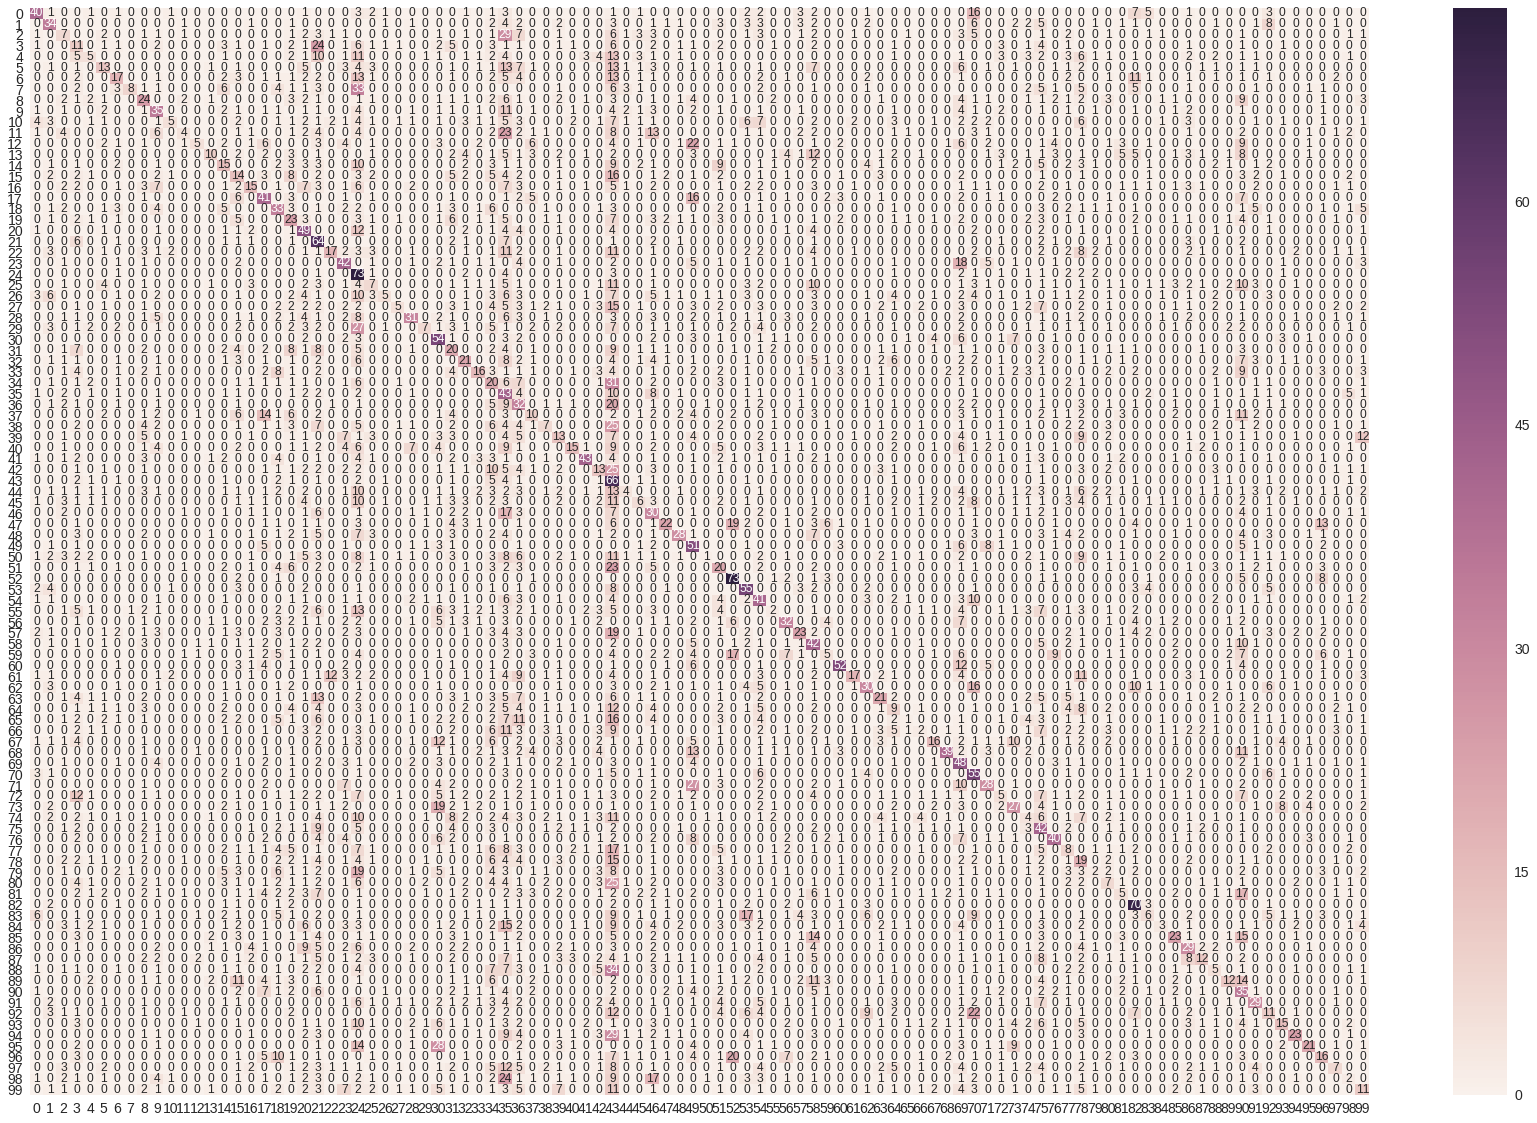


Classification Report
             precision    recall  f1-score   support

          0       0.53      0.40      0.46       100
          1       0.39      0.34      0.36       100
          2       0.12      0.07      0.09       100
          3       0.08      0.11      0.09       100
          4       0.14      0.05      0.07       100
          5       0.25      0.13      0.17       100
          6       0.31      0.17      0.22       100
          7       0.80      0.08      0.15       100
          8       0.24      0.24      0.24       100
          9       0.31      0.35      0.33       100
         10       0.38      0.05      0.09       100
         11       0.25      0.04      0.07       100
         12       0.38      0.05      0.09       100
         13       0.42      0.10      0.16       100
         14       0.19      0.15      0.17       100
         15       0.12      0.14      0.13       100
         16       0.31      0.15      0.20       100
         17       0.31

In [24]:
print('Confusion Matrix')
cm = confusion_matrix(np.argmax(y_test, axis=1), rnn_predicted)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
print('Classification Report')
print(classification_report(np.argmax(y_test, axis=1), rnn_predicted))

#### Curva ROC

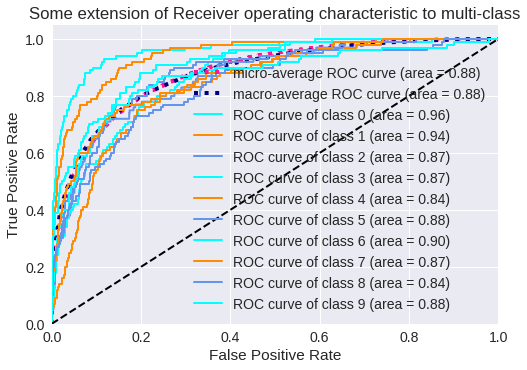

In [25]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], rnn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), rnn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()